In [3]:
import sys
sys.path.insert(1,'..')

import models
import inference
import loader 
import jax
import jax.numpy as jnp
from numpyro import optim

import visualizations
import yaml
import os
import evaluation
import numpyro

%load_ext autoreload
%autoreload 2

In [4]:
# Some global parameters

seed=0 # for reproducibility
save=False # save plots in the file 
file='../../results/gpwp/' # file address for saving

In [14]:
# Load parameter configuration from the config file

config = '../configs/GPWP.yaml'
with open(config, 'r') as stream: pm = yaml.safe_load(stream)
dataset_params, model_params, variational_params, visualization_params, comparison_params = pm['dataset_params'], pm['model_params'], pm['variational_params'], pm['visualization_params'], pm['comparison_params']

In [15]:
# Create a data loader that generates synthetic data based on the parameters in the config file (configs/GPWP.yaml)

dataloader = loader.GPWPLoader(dataset_params)
x,y = dataloader.load_data()
x_test, y_test = dataloader.load_test_data()

In [16]:
# Create instances of prior models (GP, WP) and likelihood and joint models using the parameters in the config file (configs/GPWP.yaml)

gp_kernel = loader.get_kernel(model_params['gp_kernel'],model_params['gp_kernel_diag'])
D = y.shape[2]

print('Trials, Conditions, Neurons: ', y.shape)

gp = models.GaussianProcess(kernel=gp_kernel,num_dims=D)
empirical = jnp.cov((y - y.mean(0)[None]).reshape(y.shape[0]*y.shape[1],y.shape[2]).T)

wp_kernel = loader.get_kernel(model_params['wp_kernel'],model_params['wp_kernel_diag'])

nu = model_params['nu'] if 'nu' in model_params.keys() else model_params['nu_scale']*D
optimize_L = True if 'optimize_L' in model_params.keys() and model_params['optimize_L'] else False
wp = models.WishartProcess(
    kernel=wp_kernel,nu=nu,
    V=empirical,optimize_L=optimize_L
)

likelihood = eval('models.'+model_params['likelihood'])(D)
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

print(gp.evaluate_kernel(x,x).max())
print(wp.evaluate_kernel(x,x).max())

Trials, Conditions, Neurons:  (8, 30, 100)
1.001
1.001


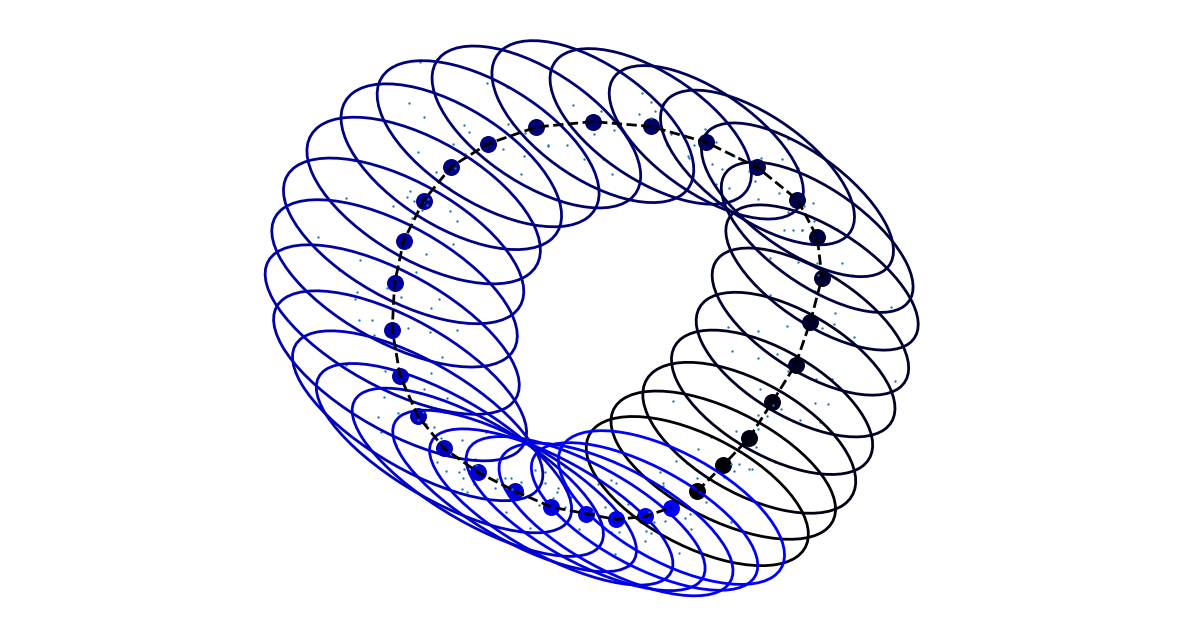

In [17]:
# Plot the true means and covariances, and data trials

visualizations.visualize_pc(
    jnp.concatenate((dataloader.mu,dataloader.mu_test))[:,None],
    jnp.concatenate((dataloader.sigma,dataloader.sigma_test)),
    pc=y.reshape(y.shape[0]*y.shape[1],-1),
    dotsize=500,
    linewidth=2
)

In [18]:
# Initialize the variational family and run posterior inference and plot ELBO loss

init = {'G':dataloader.mu.T[:,None],'F':dataloader.F}

varfam = eval('inference.'+variational_params['guide'])(
    joint.model,init=init
)
optimizer = eval('optim.'+variational_params['optimizer']['type'])(
    variational_params['optimizer']['step_size']
)
key = jax.random.PRNGKey(seed)

varfam.infer(
    optimizer,x,y,
    n_iter=variational_params['n_iter'],key=key,
    num_particles=variational_params['num_particles']
)
joint.update_params(varfam.posterior)

visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',
    titlestr='Training Loss',colors=['k'],
)


100%|██████████| 50000/50000 [00:56<00:00, 885.14it/s, init loss: 601022.5000, avg. loss [47501-50000]: 23358.2207] 


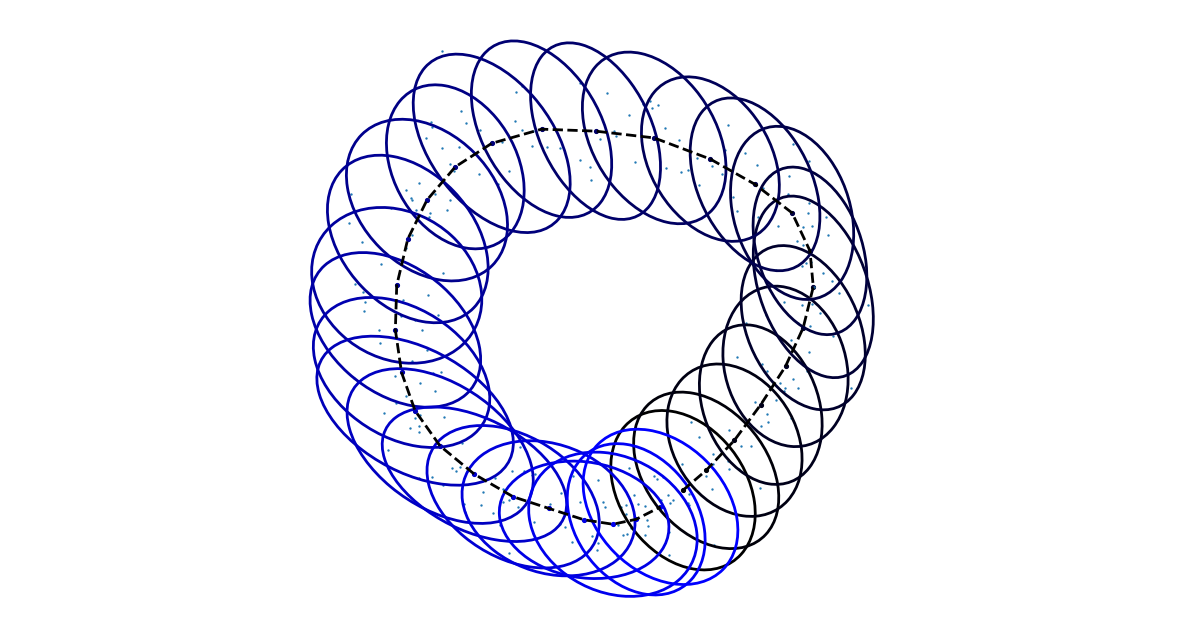

In [19]:
# Create the posterior distribution instance and sample from it in train and test conditions and plot it

posterior = models.NormalGaussianWishartPosterior(joint,varfam,x)
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(x)
    mu_prime, sigma_prime = posterior.derivative(x)

with numpyro.handlers.seed(rng_seed=seed):
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(x_test)
    mu_test_prime, sigma_test_prime = posterior.derivative(x_test)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,
    pc=y.reshape(y.shape[0]*y.shape[1],-1),
)


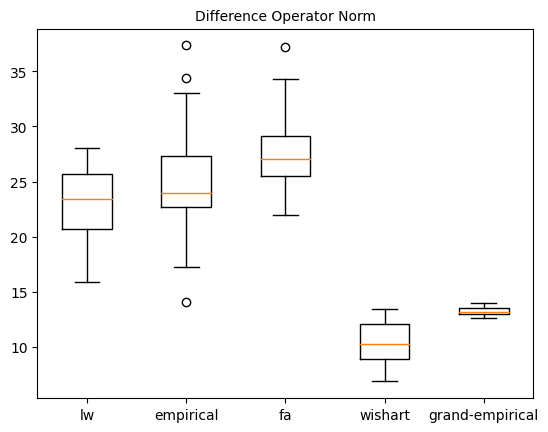

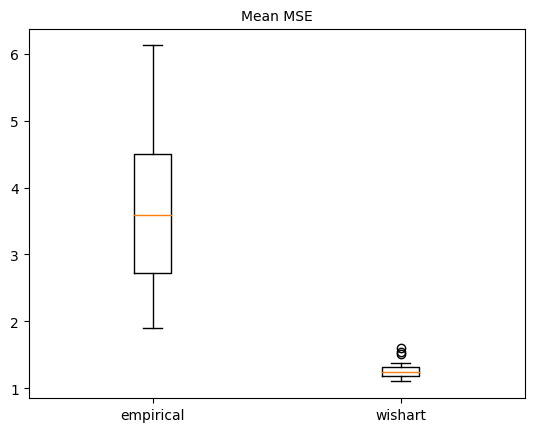

In [20]:
# Evaluate the performance of mean and covariance estimationthe model using MSE and operator norm

compared = evaluation.compare(y,params=comparison_params)
compared['wishart'] = sigma_hat.transpose(1,2,0)
compared['grand-empirical'] = jnp.repeat(empirical[:,:,None],y.shape[1],2)

performance = evaluation.evaluate(compared,dataloader.sigma.transpose(1,2,0))

visualizations.plot_box(
    performance,titlestr='Difference Operator Norm',
)

mse = lambda x,y: jnp.sqrt(((x-y)**2).sum(-1))

mu_empirical = y.mean(0)
performance_mean = {}
performance_mean['empirical'] = mse(mu_empirical,dataloader.mu)
performance_mean['wishart'] = mse(mu_hat,dataloader.mu)

visualizations.plot_box(
    performance_mean,titlestr='Mean MSE',
    save=save,file=file+'comparison'
)

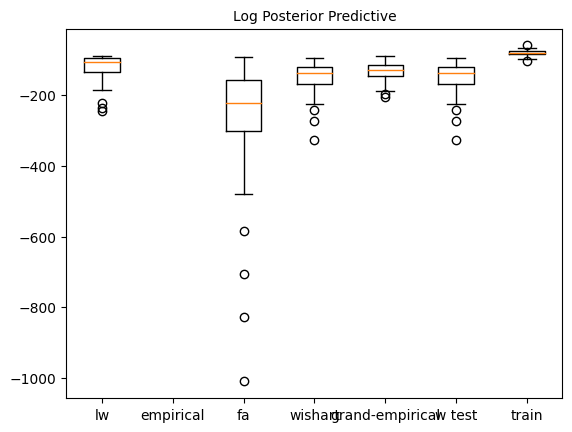

In [21]:
# Compute log likelihood on test trials for evaluation

lpp = {}
mu_empirical = y.mean(0)

for key in compared.keys():
    lpp[key] = likelihood.log_prob(y_test['x'],mu_empirical,compared[key].transpose(2,0,1)).flatten()

lpp['w test'] = likelihood.log_prob(y_test['x'], mu_empirical, sigma_hat).flatten()
lpp['train'] = likelihood.log_prob(y,dataloader.mu,dataloader.sigma).flatten()

visualizations.plot_box(
    lpp,titlestr='Log Posterior Predictive',
)